[Link](https://www.dcjingsai.com/common/cmpt/%E5%91%98%E5%B7%A5%E7%A6%BB%E8%81%8C%E9%A2%84%E6%B5%8B%E8%AE%AD%E7%BB%83%E8%B5%9B_%E6%8E%92%E8%A1%8C%E6%A6%9C.html)

# 导入工具

In [33]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import json

TEMP_FOLDER = os.path.abspath('./temp/')
print(f"文件夹 '{TEMP_FOLDER}' 将被用来存储语料和临时性字典")

import logging
logging.basicConfig(format="%(asctime)s: %(levelname)s: %(message)s", level=logging.INFO)

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_column', 200)

import pandas_profiling

import seaborn as sns
sns.set()
import matplotlib.pyplot as  plt
import matplotlib.patches as patches
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline

from sklearn.decomposition import FactorAnalysis, FastICA, PCA, TruncatedSVD
from sklearn.manifold import Isomap, TSNE
import umap

from tqdm import tqdm_notebook

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool, cv

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.preprocessing import Imputer, Normalizer, scale, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(tf.__version__)

文件夹 'D:\Github\NLP\Kaggle\员工离职预测_dc\temp' 将被用来存储语料和临时性字典
2.0.0


# Helper Functions

In [2]:
def plot_categories(df, cat, target , **kwargs):
    row = kwargs.get('row' , None)
    col = kwargs.get('col' , None)
    facet = sns.FacetGrid(df , row=row , col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

In [3]:
def highlight_corr(s, threshold=.2):
    is_related = (s > threshold) & (s < 1)
    return ['background-color: yellow' if v else '' for v in is_related]

In [15]:
def plot_model_var_imp(model,X, y):
    imp = pd.DataFrame(model.feature_importances_, columns=['Importance'], index=X.columns)
    imp = imp.sort_values(['Importance' ], ascending = True)
    imp[: 10].plot(kind = 'barh')
    print(model.score(X, y))
    
def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X, y)
    plot_model_var_imp(tree,X, y)

# 数据处理

In [4]:
train_df = pd.read_csv('data/pfm_train.csv')
test_df = pd.read_csv('data/pfm_test.csv')

In [6]:
train_labels = train_df.Attrition
train_df.drop(['Attrition'], axis=1, inplace=True)
full_data_raw = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_data_raw.tail(3)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1447,30,Travel_Rarely,Research & Development,1,3,Life Sciences,806,4,Male,1,...,3,80,2,7,2,3,2,2,0,2
1448,24,Travel_Frequently,Research & Development,7,3,Life Sciences,647,1,Female,3,...,4,80,1,6,4,3,6,3,1,2
1449,33,Travel_Rarely,Research & Development,7,3,Medical,817,3,Male,3,...,4,80,0,14,3,4,13,9,3,7


## 文字型类别值转换

### 法1：转换为整形数字

In [18]:
# 独热转换，可以用pd.get_dummies()，此处转换成单个整型数值
full_data = full_data_raw.copy()
for column in  full_data_one_hot.select_dtypes(object).columns:
    full_data[column] = full_data[column].astype('category').cat.codes

In [22]:
# 去除常量，高相关属性
full_data.drop(['EmployeeNumber', 'Over18', 'StandardHours'], axis=1, inplace=True)

In [23]:
full_data.tail()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1445,24,2,2,10,4,2,4,0,3,2,...,3,4,1,5,2,4,5,2,0,3
1446,36,2,1,3,2,1,4,1,4,2,...,4,1,1,13,3,3,5,4,0,4
1447,30,2,1,1,3,1,4,1,1,1,...,4,3,2,7,2,3,2,2,0,2
1448,24,1,1,7,3,1,1,0,3,1,...,3,4,1,6,4,3,6,3,1,2
1449,33,2,1,7,3,3,3,1,3,3,...,3,4,0,14,3,4,13,9,3,7


In [24]:
full_data.corr().style.apply(highlight_corr, args=(.2,))

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1,0.0259136,-0.0349819,-0.00760037,0.207929,-0.0417782,0.00953943,-0.0317196,0.032366,0.512555,-0.122534,-0.00844074,-0.0914669,0.498683,0.299407,0.0323438,0.00819507,0.00601485,0.0494849,0.035449,0.678321,-0.0206739,-0.0171781,0.304106,0.208341,0.209139,0.199053
BusinessTravel,0.0259136,1,-0.00874139,-0.0234782,0.00290753,0.0213241,-0.00564108,-0.0326557,0.0353024,0.0139323,0.00523216,-0.0379042,0.0242377,0.0296006,0.023312,0.0137743,-0.0318933,-0.0303613,-0.0365945,-0.0169585,0.0310138,0.0173577,-0.0147943,-0.0191581,-0.0133505,-0.0376218,-0.0256591
Department,-0.0349819,-0.00874139,1,0.0204919,0.0052882,0.0153249,-0.0205844,-0.036738,-0.0231029,0.100652,0.665253,0.0208977,0.0575821,0.0507351,-0.0382153,0.00811911,-0.00809755,-0.0230753,-0.0249846,-0.0115758,-0.0194071,0.038451,0.0243699,0.0214293,0.0547539,0.0439918,0.0323649
DistanceFromHome,-0.00760037,-0.0234782,0.0204919,1,0.0199405,0.00114422,-0.0162629,-0.000208995,0.00959621,0.0082104,0.000610262,-0.00641258,-0.0151875,-0.0180614,-0.0276649,0.0270781,0.0399214,0.0250948,0.00425602,0.0454513,-0.00199439,-0.0354717,-0.0294343,0.00299166,0.018978,-0.00136833,0.00786541
Education,0.207929,0.00290753,0.0052882,0.0199405,1,-0.0330736,-0.028633,-0.0115528,0.0387263,0.0969009,0.00216063,-0.0154189,0.00344936,0.0899967,0.128999,-0.0186439,-0.0077682,-0.0237934,-0.00760683,0.0190794,0.144007,-0.0213986,0.00642986,0.0636152,0.0562274,0.0500874,0.0676226
EducationField,-0.0417782,0.0213241,0.0153249,0.00114422,-0.0330736,1,0.0391779,-0.00656154,-0.00283304,-0.0385408,0.0177062,-0.0336811,0.00837652,-0.0340832,-0.0116668,0.00274508,-0.0104824,-0.00562743,-0.0102522,-0.0126676,-0.025108,0.0429125,0.0450541,-0.0163031,-0.00725939,0.00440462,-0.000504668
EnvironmentSatisfaction,0.00953943,-0.00564108,-0.0205844,-0.0162629,-0.028633,0.0391779,1,0.0028415,-0.0132161,-0.00385129,-0.0203493,-0.00466179,-0.00858562,-0.0109627,0.011049,0.0686734,-0.0294709,-0.0313352,0.00627293,0.00419577,-0.00717057,-0.0180509,0.0260451,-0.00255843,0.0137232,0.0117753,-0.0117134
Gender,-0.0317196,-0.0326557,-0.036738,-0.000208995,-0.0115528,-0.00656154,0.0028415,1,0.0205967,-0.0362565,-0.0366358,0.0382995,-0.0474214,-0.0277048,-0.0430969,-0.0404896,0.00291774,-0.0132435,0.0231586,0.0118762,-0.038942,-0.0427264,-0.000797205,-0.0205197,-0.0328515,-0.0252617,-0.0246976
JobInvolvement,0.032366,0.0353024,-0.0231029,0.00959621,0.0387263,-0.00283304,-0.0132161,0.0205967,1,-0.012727,0.00227598,-0.0225488,-0.0414156,-0.0151345,0.012311,-0.00357514,-0.0123663,-0.0265936,0.0345394,0.0219655,-0.00545467,-0.0114659,-0.0162405,-0.020508,0.00820342,-0.0282339,0.0298547
JobLevel,0.512555,0.0139323,0.100652,0.0082104,0.0969009,-0.0385408,-0.00385129,-0.0362565,-0.012727,1,-0.0835891,-0.00306667,-0.0746526,0.950108,0.14596,0.00271018,-0.0319051,-0.0207254,0.0222564,0.00967713,0.784254,-0.0146801,0.0319148,0.535986,0.390557,0.354459,0.374291


In [29]:
# 添加计数特征
for i in tqdm_notebook(full_data.columns):
    full_data['count_' + i] = full_data.groupby([i])[i].transform('count')

In [35]:
full_data.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,count_Age,count_BusinessTravel,count_Department,count_DistanceFromHome,count_Education,count_EducationField,count_EnvironmentSatisfaction,count_Gender,count_JobInvolvement,count_JobLevel,count_JobRole,count_JobSatisfaction,count_MaritalStatus,count_MonthlyIncome,count_NumCompaniesWorked,count_OverTime,count_PercentSalaryHike,count_PerformanceRating,count_RelationshipSatisfaction,count_StockOptionLevel,count_TotalWorkingYears,count_TrainingTimesLastYear,count_WorkLifeBalance,count_YearsAtCompany,count_YearsInCurrentRole,count_YearsSinceLastPromotion,count_YearsWithCurrManager
0,37,2,1,1,4,1,1,1,2,2,4,3,0,5993,1,0,18,3,3,1,7,2,4,7,5,0,7,50,1031,946,206,393,595,278,870,367,527,142,434,323,2,515,1035,89,1226,451,585,81,536,152,90,36,576,213
1,54,1,1,1,4,1,4,0,3,3,4,3,0,10502,7,0,17,3,1,1,33,2,1,5,4,1,4,18,272,946,206,393,595,438,580,859,215,142,434,323,1,72,1035,81,1226,274,585,7,536,78,193,103,352,96
2,34,1,1,7,3,1,1,1,1,2,2,3,2,6074,1,1,24,4,4,0,9,3,3,9,7,0,6,76,272,946,83,564,595,278,870,82,527,255,434,464,1,515,415,21,224,425,623,94,487,878,81,220,576,28
3,39,2,1,1,1,1,4,0,2,4,4,4,1,12742,1,0,16,3,3,1,21,3,3,21,6,11,8,41,1031,946,206,169,595,438,580,367,103,142,455,663,1,515,1035,77,1226,451,585,32,487,878,14,36,23,104
4,28,1,1,1,3,3,1,1,2,1,2,2,0,2596,1,0,15,3,1,2,1,2,3,1,0,0,0,48,272,946,206,564,459,278,870,367,538,255,277,323,1,515,1035,99,1226,274,158,81,536,878,170,241,576,261


In [36]:
full_data.shape

(1450, 54)

### 法2：转为独热编码

In [14]:
full_data_one_hot = full_data_raw.copy()
# full_data_one_hot.drop(['EmployeeNumber', 'MonthlyIncome', 'Over18', 'StandardHours', 'PerformanceRating'], axis=1, inplace=True)
[c for c in  full_data_one_hot.select_dtypes(object).columns]

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [8]:
bt = pd.DataFrame()
bt = pd.get_dummies(full_data_one_hot.BusinessTravel)

In [9]:
dp = pd.DataFrame()
dp = pd.get_dummies(full_data_one_hot.Department, prefix='dp')

In [10]:
education = pd.DataFrame()
education = pd.get_dummies(full_data_one_hot.EducationField, prefix='ed')

In [11]:
jobrole = pd.DataFrame()
jobrole = pd.get_dummies(full_data_one_hot.JobRole)

In [12]:
marital = pd.DataFrame()
marital = pd.get_dummies(full_data_one_hot.MaritalStatus)

In [13]:
overtime = pd.DataFrame()
overtime = pd.get_dummies(full_data_one_hot.OverTime)

In [12]:
gender = pd.DataFrame()
gender = pd.get_dummies(full_data_one_hot.Gender)

In [13]:
for c in  full_data_one_hot.select_dtypes(object).columns:
    full_data_one_hot.drop([c], axis=1, inplace=True)

In [18]:
# 较连续值离散化1
df_clean = full_data_one_hot.copy()
imputed = pd.DataFrame()
imputed['Age'] = df_clean.Age
imputed.Age[(imputed.Age > 16) & (imputed.Age <= 30)] = 1
imputed.Age[(imputed.Age > 30) & (imputed.Age <= 40)] = 2
imputed.Age[(imputed.Age > 40) & (imputed.Age <= 50)] = 3
imputed.Age[(imputed.Age > 50) & (imputed.Age <= 60)] = 4

# 较连续值离散化2
imputed['DistanceFromHome'] = df_clean.DistanceFromHome
imputed.DistanceFromHome[(imputed.DistanceFromHome > 0) & (imputed.DistanceFromHome <= 4)] = 1
imputed.DistanceFromHome[(imputed.DistanceFromHome > 4) & (imputed.DistanceFromHome <= 9)] = 2
imputed.DistanceFromHome[(imputed.DistanceFromHome > 9) & (imputed.DistanceFromHome <= 30)] = 3

# 较连续值离散化3
imputed['PercentSalaryHike'] = df_clean.PercentSalaryHike
imputed.PercentSalaryHike[imputed.PercentSalaryHike < 20] = 0
imputed.PercentSalaryHike[imputed.PercentSalaryHike >= 20] = 1

# 较连续值离散化4
imputed['TotalWorkingYears'] = df_clean.TotalWorkingYears
imputed.TotalWorkingYears[imputed.TotalWorkingYears <= 10] = 0
imputed.TotalWorkingYears[(imputed.TotalWorkingYears > 10) & (imputed.TotalWorkingYears < 25)] = 1
imputed.TotalWorkingYears[imputed.TotalWorkingYears >= 25] = 2

# 较连续值离散化5
imputed['YearsAtCompany'] = df_clean.YearsAtCompany
imputed.YearsAtCompany[imputed.YearsAtCompany <= 3] = 0
imputed.YearsAtCompany[(imputed.YearsAtCompany > 3) & (imputed.TotalWorkingYears < 7)] = 1
imputed.YearsAtCompany[imputed.YearsAtCompany >= 7] = 2

# 较连续值离散化6
imputed['YearsInCurrentRole'] = df_clean.YearsInCurrentRole
imputed.YearsInCurrentRole[imputed.YearsInCurrentRole <= 5] = 0
imputed.YearsInCurrentRole[(imputed.YearsInCurrentRole > 5) & (imputed.TotalWorkingYears < 10)] = 1
imputed.YearsInCurrentRole[imputed.YearsInCurrentRole >= 10] = 2

# 较连续值离散化7
imputed['YearsWithCurrManager'] = df_clean.YearsWithCurrManager
imputed.YearsWithCurrManager[imputed.YearsWithCurrManager <= 2] = 0
imputed.YearsWithCurrManager[(imputed.YearsWithCurrManager > 2) & (imputed.TotalWorkingYears < 12)] = 1
imputed.YearsWithCurrManager[imputed.YearsWithCurrManager >= 12] = 2
imputed.head(3)

,Age,DistanceFromHome,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
0,2,1,0,0,1,0,1
1,4,1,0,2,1,0,1
2,2,2,1,0,1,1,1


In [38]:
for column in imputed.columns:
    df_clean[column] = imputed[column]
df_clean.tail(3)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1447,1,2,1,1,3,1,4,1,1,2,...,1,3,2,0,2,3,0,0,0,0
1448,1,1,1,2,3,1,1,3,1,2,...,0,4,1,0,4,3,1,0,1,0
1449,2,2,1,2,3,3,3,3,3,5,...,0,4,0,1,3,4,1,1,3,1


### 权重重分配

In [42]:
# # not good
# neg, pos = train_labels.value_counts()
# total = len(train_labels)
# neg_weight = (1/neg) * total / 2.
# pos_weight = (1/pos) * total / 2.
# class_weight = {0:neg_weight, 1:pos_weight}

## 特征选择与组合

待组合
- BusinessTravel
- EnvironmentSatisfaction
- Jobinvolvement
- JobLevel
- JobRole：销售代表的离职率很高，接近40%，考虑将这个属性变成是否为销售代表
- JobSatisfaction
- MaritalStatus: 单身人员离职率更高
- OverTime
- PercentSalaryHike: 工资提高比，24个点的超过40%离职，牛人更频繁离职，属性转换成是否高于20%

# 模型
- 模型得分差不太多，简单的逻辑斯蒂回归应该作为baseline，连这个分数差不过的话，模型太复杂就没有意义
- 特征处理模型选择更重要些

In [37]:
random_state = 42
kfold = StratifiedKFold(n_splits=10)

In [38]:
train_data, test_data = full_data[:len(train_df)], full_data[len(train_df):]
train_data.shape, test_data.shape

((1100, 54), (350, 54))

In [46]:
LR = LogisticRegression()
lr_param_grid = {'penalty': ['l1','l2'],
                'C': [.001, .01, .1, 1, 10],
                'max_iter': [100,300,500,1000]}
gsLR = GridSearchCV(LR, param_grid=lr_param_grid, cv=kfold, scoring='accuracy', verbose=1)
gsLR.fit(train_data, train_labels)
lr_best = gsLR.best_estimator_
gsLR.best_score_, lr_best

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   53.6s finished


(0.8772727272727273,
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False))

In [47]:
confusion_matrix(train_labels,lr_best.predict(train_data))

array([[904,  18],
       [109,  69]], dtype=int64)

In [45]:
LR = LogisticRegression(penalty='l1', C=1, max_iter=100)
LR.fit(train_data, train_labels)
ypred = LR.predict(train_data)
print(classification_report(train_labels, ypred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       922
           1       0.75      0.35      0.48       178

    accuracy                           0.88      1100
   macro avg       0.82      0.67      0.71      1100
weighted avg       0.86      0.88      0.86      1100



In [57]:
confusion_matrix(train_labels,ypred)

array([[901,  21],
       [115,  63]], dtype=int64)

In [70]:
fn = np.where((train_labels != ypred) & (ypred == 0))[0]

In [23]:
from itertools import combinations

def auto_feature_choice(df_raw, train_labels, baseline=.875):
    result = ''
    df = df_raw.copy()
    column_list = []
    for c in df.columns:
        if df[c].dtype != 'object':
            column_list.append(c)
            
    choices = list(combinations(column_list, 2))
    for choice in choices:
        values = [(x, y) for x in df[choice[0]].unique() for y in df[choice[1]].unique()]
        
        temp = pd.DataFrame()
        for i, (x, y) in enumerate(values):
            name = ' '.join(choice) + str(i)
            temp[name] = ((df[choice[0]] == x) & (df[choice[1]] == y)).astype(int)
            temp[name+'multi'] = df[choice[0]] * df[choice[1]]
            
        new_df = pd.concat([df, temp], axis=1)
        train_data = new_df[:len(train_labels)]
        
#         estimator = LogisticRegression(penalty='l1', C=1, max_iter=100)
        estimator = RandomForestClassifier(max_features=30, max_depth=10, 
                             min_samples_leaf=3, min_samples_split=3,
                            n_estimators=100)
        
        estimator.fit(train_data, train_labels)
        ypred = estimator.predict(train_data)
        val_score = np.mean(cross_val_score(estimator, train_data, train_labels))
        
        if val_score > baseline:
            baseline = val_score
            result = new_df
            print(choice, val_score)
    return result if result else df_raw

In [ ]:
final_df = auto_feature_choice(full_data_imputed, train_labels)
final_df.tail(3)

In [15]:
full_data_oh_new = pd.concat([full_data_one_hot, bt, dp, education, jobrole, marital, overtime, gender], axis=1)
full_data_oh_new.head(3)

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,...,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single,No,Yes,Female,Male
0,37,1,4,1,2,2,3,1,18,3,...,0,0,0,1,0,0,1,0,0,1
1,54,1,4,4,3,3,3,7,17,1,...,0,0,0,1,0,0,1,0,1,0
2,34,7,3,1,1,2,3,1,24,4,...,0,0,0,0,0,1,0,1,0,1


In [19]:
full_data_imputed = full_data_oh_new.copy()
for c in imputed.columns:
    full_data_imputed[c] = imputed[c]
full_data_imputed.head(3)

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,...,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single,No,Yes,Female,Male
0,2,1,4,1,2,2,3,1,0,3,...,0,0,0,1,0,0,1,0,0,1
1,4,1,4,4,3,3,3,7,0,1,...,0,0,0,1,0,0,1,0,1,0
2,2,2,3,1,1,2,3,1,1,4,...,0,0,0,0,0,1,0,1,0,1


In [26]:
full_data_imputed.shape

(1450, 46)

In [13]:
# train_data = full_data_imputed[:len(train_labels)]
cat_model = CatBoostClassifier(custom_loss=['Accuracy'], random_seed=42)
cat_model.fit(train_data, train_labels, logging_level='Verbose')

Learning rate set to 0.017212
0:	learn: 0.6807056	total: 82.2ms	remaining: 1m 22s
1:	learn: 0.6676880	total: 106ms	remaining: 53.1s
2:	learn: 0.6559296	total: 133ms	remaining: 44.1s
3:	learn: 0.6460322	total: 152ms	remaining: 37.9s
4:	learn: 0.6360090	total: 182ms	remaining: 36.2s
5:	learn: 0.6243382	total: 210ms	remaining: 34.9s
6:	learn: 0.6154630	total: 236ms	remaining: 33.5s
7:	learn: 0.6053423	total: 260ms	remaining: 32.2s
8:	learn: 0.5941512	total: 283ms	remaining: 31.2s
9:	learn: 0.5855038	total: 307ms	remaining: 30.4s
10:	learn: 0.5762483	total: 331ms	remaining: 29.8s
11:	learn: 0.5670640	total: 358ms	remaining: 29.5s
12:	learn: 0.5596632	total: 382ms	remaining: 29s
13:	learn: 0.5508926	total: 406ms	remaining: 28.6s
14:	learn: 0.5436357	total: 430ms	remaining: 28.2s
15:	learn: 0.5357889	total: 454ms	remaining: 27.9s
16:	learn: 0.5284492	total: 477ms	remaining: 27.6s
17:	learn: 0.5226567	total: 501ms	remaining: 27.3s
18:	learn: 0.5165193	total: 524ms	remaining: 27.1s
19:	learn: 

In [14]:
cross_val_score(cat_model, train_data, train_labels)

Learning rate set to 0.015338
0:	learn: 0.6837480	total: 20ms	remaining: 19.9s
1:	learn: 0.6738122	total: 42.6ms	remaining: 21.3s
2:	learn: 0.6632512	total: 64.9ms	remaining: 21.6s
3:	learn: 0.6553098	total: 81.3ms	remaining: 20.2s
4:	learn: 0.6463535	total: 105ms	remaining: 20.8s
5:	learn: 0.6361824	total: 127ms	remaining: 21s
6:	learn: 0.6267346	total: 150ms	remaining: 21.2s
7:	learn: 0.6185851	total: 176ms	remaining: 21.8s
8:	learn: 0.6099103	total: 203ms	remaining: 22.3s
9:	learn: 0.6002017	total: 228ms	remaining: 22.6s
10:	learn: 0.5923603	total: 253ms	remaining: 22.7s
11:	learn: 0.5855508	total: 277ms	remaining: 22.8s
12:	learn: 0.5801345	total: 288ms	remaining: 21.9s
13:	learn: 0.5728608	total: 310ms	remaining: 21.9s
14:	learn: 0.5669042	total: 334ms	remaining: 21.9s
15:	learn: 0.5609988	total: 352ms	remaining: 21.7s
16:	learn: 0.5539558	total: 375ms	remaining: 21.7s
17:	learn: 0.5458628	total: 401ms	remaining: 21.9s
18:	learn: 0.5405201	total: 425ms	remaining: 21.9s
19:	learn: 

array([0.875     , 0.86885246, 0.86885246])

In [325]:
values1 = [('Education','TotalWorkingYears',c,d) for c in final_df.Education.unique() for d in final_df.TotalWorkingYears.unique()]
values2 = [('Age', 'TotalWorkingYears', c,d) for c in final_df.Age.unique() for d in final_df.TotalWorkingYears.unique()]
values3 = [('Age', 'JobLevel', c,d) for c in final_df.Age.unique() for d in final_df.JobLevel.unique()]
values4 = [('YearsAtCompany', 'JobLevel', c,d) for c in final_df.YearsAtCompany.unique() for d in final_df.JobLevel.unique()]

In [329]:
temp = pd.DataFrame()
for i, value in enumerate([values1, values2, values3, values4]):
    for j, (c1, c2, x, y) in enumerate(value):
        name = str(i) + str(j)
        temp[name] = ((final_df[c1] == x) & (final_df[c2] == y)).astype(int)

In [333]:
temp.shape

(1450, 57)

In [332]:
brand_new = pd.concat([full_data_imputed, temp], axis=1)
brand_new.shape

(1450, 103)

In [335]:
train_data = brand_new[:len(train_labels)]
LR = LogisticRegression(penalty='l1', C=1, max_iter=100)
LR.fit(train_data, train_labels)
ypred = LR.predict(train_data)
val_score = np.mean(cross_val_score(LR, train_data, train_labels))
val_score

0.8699908925318761

In [337]:
LR = LogisticRegression(penalty='l1', C=1, max_iter=100)
lr_param_grid = {'C': [.01, .1, 1, ],
                'max_iter': [100,300]}
gsLR = GridSearchCV(LR, param_grid=lr_param_grid, cv=kfold, scoring='accuracy', verbose=1)
gsLR.fit(train_data, train_labels)
lr_best = gsLR.best_estimator_
gsLR.best_score_, lr_best

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


(0.8736363636363637,
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False))

In [336]:
LR = LogisticRegression(penalty='l1', C=1, max_iter=100)
LR.fit(train_data2, train_labels)
ypred = LR.predict(train_data2)
np.mean(cross_val_score(LR, train_data2, train_labels))

0.8754504236952562

In [46]:
submission_lr = LR.predict(test_data)

In [48]:
sub_lr = pd.DataFrame(submission_lr, columns=['result'])

In [55]:
sub_lr.to_csv('submission_lr.csv', index=False)

In [56]:
temp = pd.read_csv('submission_lr.csv')
temp.head()

,result
0,0
1,0
2,0
3,0
4,0


In [338]:
GBC = GradientBoostingClassifier(max_depth=8, max_features=.1, min_samples_leaf=100, n_estimators=200)
GBC.fit(train_data, train_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=8,
                           max_features=0.1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [339]:
cross_val_score(GBC, train_data, train_labels, cv=kfold)

array([0.86877828, 0.8959276 , 0.85909091, 0.85844749, 0.85844749])

1.0


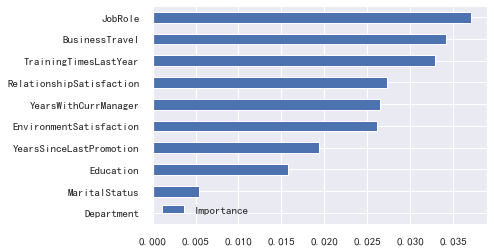

In [25]:
plot_variable_importance(full_data[:len(train_df)], train_labels)

In [ ]:
models = []
models.append(SVC(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
             random_state=random_state, learning_rate=.1))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(KNeighborsClassifier())
models.append(LogisticRegression(random_state=random_state))

cv_results = []
for model in models:
    cv_results.append(cross_val_score(model, x_train, y_train, scoring='accuracy', cv=kfold))
    
cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors": cv_stds,
                       "Algorithm":["SVC","DecisionTree",
                                    "AdaBoost",
                                    "RandomForest","ExtraTrees",
                                    "GradientBoosting",
                                    "KNeighboors",
                                    "LogisticRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_stds})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [113]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsadaDTC.fit(train_data2,train_labels)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    5.7s finished


0.7845454545454545

In [135]:
gsadaDTC.best_params_

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'gini',
 'base_estimator__splitter': 'random',
 'learning_rate': 0.0001,
 'n_estimators': 1}

In [361]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsExtC.fit(x_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_, ExtC_best

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.5min finished


(0.8654545454545455,
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None, verbose=0,
                      warm_start=False))

In [360]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5, 8, 10, 13],
              "max_features": [1, 3, 10, 20, 30],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators" :[100,300, 500, 1000],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", verbose = 1, n_jobs=4)

gsRFC.fit(train_data,train_labels)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_, RFC_best

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 13.4min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 17.8min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 23.2min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 28.8min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 35.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 43.5min
[Parallel(n_jobs=4)]: Done 7200 out of 7200 | elapsed: 43.6min finished


(0.8690909090909091,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=10, max_features=30, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=3,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

In [342]:
print(classification_report(train_labels, RFC_best.predict(train_data)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       178

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100



In [359]:
RFC_best = RandomForestClassifier(max_features=30, min_samples_leaf=2, min_samples_split=6, n_estimators=400)
RFC_best.fit(train_data, train_labels)
cross_val_score(RFC_best, train_data, train_labels)

array([0.86141304, 0.86612022, 0.84699454])

In [352]:
sub_rfc = RFC_best.predict(brand_new[len(train_labels):])
sub_rfc = pd.DataFrame(sub_gbc, columns=['result'])
sub_rfc.to_csv('submission_rfc.csv', index=False)
temp = pd.read_csv('submission_rfc.csv')
temp.head()

,result
0,0
1,0
2,0
3,0
4,0


In [341]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsGBC.fit(train_data,train_labels)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_, gsGBC.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.4min finished


(0.8781818181818182,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 8,
  'max_features': 0.1,
  'min_samples_leaf': 150,
  'n_estimators': 200})

In [343]:
print(classification_report(GBC_best.predict(train_data), train_labels))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1009
           1       0.44      0.87      0.59        91

    accuracy                           0.90      1100
   macro avg       0.72      0.89      0.76      1100
weighted avg       0.94      0.90      0.91      1100



In [351]:
sub_gbc = GBC_best.predict(brand_new[len(train_labels):])
sub_gbc = pd.DataFrame(sub_gbc, columns=['result'])
sub_gbc.to_csv('submission_gbc.csv', index=False)
temp = pd.read_csv('submission_gbc.csv')
temp.head()

In [318]:
XGB = xgb.XGBClassifier(n_jobs=4)
xgb_param_grid = {'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8]
              }

gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsXGB.fit(x_train,y_train)

XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_, gsXGB.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   11.6s finished


(0.8681818181818182,
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200})

In [191]:
LGB = lgb.LGBMClassifier()
lgb_param_grid = {'num_leaves': [21, 31, 41],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              }

gsLGB = GridSearchCV(LGB,param_grid = lgb_param_grid, cv=kfold, scoring="accuracy", verbose=1)

gsLGB.fit(x_train,y_train)

LGB_best = gsLGB.best_estimator_

# Best score
gsLGB.best_score_, LGB_best

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   23.4s finished


(0.86,
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.05, max_depth=8,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=200, n_jobs=-1, num_leaves=21, objective=None,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

In [340]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(x_train, y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_, SVMC_best

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:   15.3s finished


(0.8663636363636363, SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False))

In [355]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(x_train, y_train)

In [356]:
voting_pred = votingC.predict(x_train)

In [358]:
print(classification_report(y_train, voting_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       922
           1       1.00      1.00      1.00       178

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100



In [139]:
confusion_matrix(gsGBC.predict(x_train), y_train)

array([[913,  84],
       [  9,  94]], dtype=int64)

In [146]:
confusion_matrix(gsRFC.predict(x_train), y_train)

array([[922,   0],
       [  0, 178]], dtype=int64)

In [147]:
confusion_matrix(gsadaDTC.predict(x_train), y_train)

array([[922,   0],
       [  0, 178]], dtype=int64)

In [148]:
confusion_matrix(gsExtC.predict(x_train), y_train)

array([[922,   0],
       [  0, 178]], dtype=int64)

In [143]:
accuracy_score(y_train, gsGBC.predict(x_train))

0.9154545454545454

In [145]:
accuracy_score(y_train, gsRFC.predict(x_train))

1.0

In [144]:
df_test.tail(3)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
347,30,Travel_Rarely,Research & Development,1,3,Life Sciences,806,4,Male,1,...,3,80,2,7,2,3,2,2,0,2
348,24,Travel_Frequently,Research & Development,7,3,Life Sciences,647,1,Female,3,...,4,80,1,6,4,3,6,3,1,2
349,33,Travel_Rarely,Research & Development,7,3,Medical,817,3,Male,3,...,4,80,0,14,3,4,13,9,3,7


In [150]:
df_test.drop(['MonthlyIncome', 'Over18', 'StandardHours'], axis=1, inplace=True)

In [151]:
df_test.drop(['PerformanceRating'], axis=1, inplace=True)

In [152]:
df_test.tail(3)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
347,30,Travel_Rarely,Research & Development,1,3,Life Sciences,806,4,Male,1,...,21,3,2,7,2,3,2,2,0,2
348,24,Travel_Frequently,Research & Development,7,3,Life Sciences,647,1,Female,3,...,16,4,1,6,4,3,6,3,1,2
349,33,Travel_Rarely,Research & Development,7,3,Medical,817,3,Male,3,...,11,4,0,14,3,4,13,9,3,7


In [155]:
# 独热转换，可以用pd.get_dummies()，此处转换成单个整型数值
for column in df_test.columns:
    if df_test[column].dtype == 'object':
        df_test[column] = df_test[column].astype('category').cat.codes

In [194]:
result = GBC_best.predict(df_test)

In [161]:
submission = pd.DataFrame(result)

In [174]:
submission.to_csv('submission.csv', index=False, header=['result'])

In [163]:
result.shape

(350,)

In [493]:
# 神经网络, NOT AN OPTION
model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(25,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=25, verbose=0)

model.evaluate(x_valid, y_valid)

W1028 22:51:20.863018 13316 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W1028 22:51:22.055497 13316 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


330/330 [==============================] - 0s 85us/sample - loss: 0.4218 - accuracy: 0.8242


[0.421798930384896, 0.8242424]